# Minnesota Nice Ride - Station Data

From the officially released data:

>The fields for **bike rentals** are as follows:
> 1. **Start date** (Date and time the rental began)
2. **Start station** (Descriptive name for the station where the rental began, changes if station is moved)
3. **Start terminal** (Logical name for the station/terminal where the rental began, does not change when station is moved)
4. **End date** (Date and time the rental ended)
5. **End station** (descriptive name for the station where the rental ended)
6. **End terminal** (Logical name for the station/terminal where the rental ended)
7. **Total duration** (Seconds) ( total length of the rental in seconds) 
8. **Account type** (Members have an account with Nice Ride, Casuals purchase a pass at the station)

>The fields for **stations** are as follows:
>1. **Terminal** (Logical name of station – matches Start terminal / End terminal in trip history)
2. **Station** (Station name used on maps, xml feed and station poster frame – matches Start station / End station  in trip history)
3. **Latitude** (Station location decimal latitude)
4. **Longitude** (Station location decimal longitude)
5. **Nb Docks** (Total number of bike docking points at station – indicates station size)<br>
Stations that have moved during the season or were installed late in the season may also be noted in this document.


### Basic Jupyter Notebook data

In [1]:
%reload_ext watermark
%watermark -a 'Author: James Larkin' 
print ''
%watermark -u -n -t -z
print ''
%watermark -g

Author: James Larkin

last updated: Fri Mar 17 2017 20:55:47 EDT

Git hash: bf7f3f6f3cb27b2646fff74d1f1ea06e44bab101


### Load libraries and modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm
from __future__ import division
import missingno as msno
import folium
import csv
from IPython.display import Image, HTML
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load station data

In [3]:
station_data = pd.read_csv('Data/NiceRide2016StationInfo.csv')

In [4]:
!wc -l Data/Nice*.csv

     199 Data/NiceRide2016StationInfo.csv


### Quick overview of the station data

In [5]:
station_data.shape

(199, 12)

In [6]:
station_data.head(2)

,Terminal,Number_docks,Map Frame Label,Location,Latitude,Longitude,Zip Code,City,Neighborhood,CPED Sector,Council Ward,Location Justification (network = SP or MN)
0,30000,27,100 Main Street SE,140 Main Street SE,44.984892,-93.256551,55414,Minneapolis,Nicollet Island/East Bank,Minn-East,3,Attraction
1,30001,15,25th Street & 33rd Ave S,3301 East 25th Street,44.957341,-93.223374,55406,Minneapolis,Seward,Minn-South,2,Attraction


In [7]:
station_data.tail(2)

,Terminal,Number_docks,Map Frame Label,Location,Latitude,Longitude,Zip Code,City,Neighborhood,CPED Sector,Council Ward,Location Justification (network = SP or MN)
197,30197,23,15th Ave SE & 4th Street SE,NaN,44.979876,-93.234739,55414,Minneapolis,University of MN,Minn-East,2,Minneapolis
198,30198,15,Bohemian Flats,2150 W River Pkwy,44.976223,-93.241600,55414,Minneapolis,University of MN,Minn-East,2,Minneapolis


In [8]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 12 columns):
Terminal                                       199 non-null int64
Number_docks                                   199 non-null int64
Map Frame Label                                199 non-null object
Location                                       192 non-null object
Latitude                                       199 non-null float64
Longitude                                      199 non-null float64
Zip Code                                       199 non-null int64
City                                           199 non-null object
Neighborhood                                   199 non-null object
CPED Sector                                    199 non-null object
Council Ward                                   199 non-null int64
Location Justification (network = SP or MN)    199 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 18.7+ KB


In [9]:
station_data.dtypes.value_counts()

object     6
int64      4
float64    2
dtype: int64

In [10]:
station_data.columns

Index([u'Terminal', u'Number_docks', u'Map Frame Label', u'Location',
       u'Latitude', u'Longitude', u'Zip Code', u'City', u'Neighborhood',
       u'CPED Sector', u'Council Ward',
       u'Location Justification (network = SP or MN)'],
      dtype='object')

### Rename columns for ease of typing

In [11]:
station_data = station_data.rename(columns={'Terminal': 'terminal',
                                            'Number_docks': 'number_docks',
                                            'Map Frame Label': 'map_label',
                                            'Location': 'location',
                                            'Latitude': 'latitude', 'Longitude': 'longitude',
                                            'Zip Code': 'zip', 'City': 'city',
                                            'Neighborhood': 'neighborhood',
                                            'CPED Sector': 'cped_sector',
                                            'Council Ward':'council_ward',
                                            'Location Justification (network = SP or MN)':\
                                            'loc_just'})

### Check for any null values in the dataset

In [12]:
complete = station_data.notnull().sum() * 100.0/station_data.shape[0]
complete = complete.round(2); complete.sort()
print("Percentage complete for each MN Nice Ride Station Info column: \n{0}"
      .format(complete))

Percentage complete for each MN Nice Ride Station Info column: 
location         96.48
terminal        100.00
number_docks    100.00
map_label       100.00
latitude        100.00
longitude       100.00
zip             100.00
city            100.00
neighborhood    100.00
cped_sector     100.00
council_ward    100.00
loc_just        100.00
dtype: float64


In [13]:
station_data.location.isnull().values.sum()

7

**Pretty clean station location dataset kindly provided to me by the good folks at MN Nice Ride. I only need to address seven null values in the location column. With the use of the given latitude/longitude info and such tools as geopy and geocode, sussing out those seven missing locations should be simple.**

In [14]:
station_data['coordinates'] = station_data[['latitude', 'longitude']].apply(tuple, axis=1)

### Locate our targeted rows with a null value in the location column

In [15]:
inds = pd.isnull(station_data).any(1).nonzero()[0]; inds

array([ 72, 129, 140, 174, 179, 195, 197])

### Find the addresses matching the latitude and longitude of each of those stations

In [16]:
from geopy.geocoders import Nominatim
stations = []
for x in station_data.coordinates:
    geolocator = Nominatim()
    location = geolocator.reverse(x)
    stations.append(str(location.address))

In [17]:
stations[:3]

['100 Main Street SE, Southeast Main Street, St Anthony West, Phillips, Minneapolis, Hennepin County, Minnesota, 55414, United States of America',
 '33rd. Ave. S., East 25th Street, Longfellow, Minneapolis, Hennepin County, Minnesota, 55406, United States of America',
 'Foss Center, Riverside Avenue, Marcy-Holmes, Phillips, Minneapolis, Hennepin County, Minnesota, 55454, United States of America']

In [18]:
station_addresses = []
input=stations
reader = csv.reader(stations)
for r in reader:
    station_addresses.append(r)

### Locate addresses for nulls in the location column by indexing dock_addresses 

In [19]:
station_addresses[140]

['University Av',
 ' Rice Street',
 ' St. Paul',
 ' Ramsey County',
 ' Minnesota',
 ' 55155',
 ' United States of America']

### Insert addresses into station_data dataframe

In [20]:
station_data.ix[72, 'location'] = '3598 North Irving Avenue'
station_data.ix[129, 'location'] = 'Shepard Road'
station_data.ix[140, 'location'] = 'Rice Street & University Ave W'
station_data.ix[174, 'location'] = '5010 Hiawatha Avenue'
station_data.ix[179, 'location'] = 'Portland Ave & 4th Street S'
station_data.ix[195, 'location'] = '225 19th Avenue S'
station_data.ix[197, 'location'] = '319 15th Avenue Se'

### Check again for any null values in the dataset

In [21]:
completeness = station_data.notnull().sum() * 100.0/station_data.shape[0]
completeness = completeness.round(2); completeness.sort()
print("Percentage complete for each MN Nice Ride Station Info column: \n{0}"
      .format(completeness))

Percentage complete for each MN Nice Ride Station Info column: 
terminal        100.0
number_docks    100.0
map_label       100.0
location        100.0
latitude        100.0
longitude       100.0
zip             100.0
city            100.0
neighborhood    100.0
cped_sector     100.0
council_ward    100.0
loc_just        100.0
coordinates     100.0
dtype: float64


**Excellent. Now we've a full dataset to use for any analysis.**

### Visualize all the stations in the dataset

In [22]:
Minny = station_data
minny_map = folium.Map(location=[44.986656, -93.258133],
                       tiles='Stamen Toner', zoom_start=14)
minny_map.lat_lng_popover()

for row in Minny.iterrows():
    wtg_id = str(row[1]['terminal'])
    docks =  str(row[1]['number_docks'])
    lat = row[1]['latitude']
    lng = row[1]['longitude']
    minny_map.polygon_marker(location=[lat, lng], num_sides=6, rotation=30,
                          fill_color='#B2D23A', fill_opacity=1, 
                          radius=10, popup=wtg_id+' '+ ' - n=' +docks,
                          popup_width='500px')

minny_map.polygon_marker(location=[44.9536, -93.2201], num_sides=6,
                         rotation=30, fill_color='#8B0000', radius=10,
                         popup='Nice Ride HQ')
minny_map.create_map('tc_map.html')
minny_map.render_iframe = True
minny_map

# EDA 

In [23]:
station_data.city.value_counts()

Minneapolis    149
St. Paul        50
Name: city, dtype: int64

In [24]:
minny_stations = station_data[station_data['city'] != 'St. Paul']
stp_stations = station_data[station_data['city'] != 'Minneapolis']

In [25]:
minny_stations.to_csv('Data/minny_stations.csv', index=False)
stp_stations.to_csv('Data/stp_stations.csv', index=False)

## Minneapolis

In [26]:
minny_stations.number_docks.value_counts().head(6)

15    75
19    35
23    15
27     6
25     5
11     4
Name: number_docks, dtype: int64

In [27]:
minny_stations.number_docks.sum()

2688

In [28]:
minny_stations.number_docks.mean()

18.040268456375838

In [29]:
minny_stations.neighborhood.nunique()

49

### Minneapolis station/dock information by zip code

In [30]:
minny_stations.zip.nunique()

22

In [31]:
q = pd.DataFrame(minny_stations['number_docks'].groupby([minny_stations['zip']]).sum())
q = q.rename(columns={'number_docks':'docks'})
r = pd.DataFrame(minny_stations['number_docks'].groupby(minny_stations['zip']).mean())
r = r.round(2); r = r.rename(columns={'number_docks':'d/p/s'})
s = pd.DataFrame(minny_stations['number_docks'].groupby([minny_stations['zip']]).count())
s = s.rename(columns={'number_docks':'stations'})
minny_zip = pd.concat([s, q, r], axis=1); print(minny_zip)
#print(minny_zip.sort_values('number of stations', ascending=False))

       stations  docks  d/p/s
zip                          
55401        17    320  18.82
55402         3     57  19.00
55403        15    275  18.33
55404         8    134  16.75
55405         5     79  15.80
55406         8    124  15.50
55407         4     64  16.00
55408        11    203  18.45
55409         3     41  13.67
55410         1     15  15.00
55411         8    116  14.50
55412         1     15  15.00
55413         7    105  15.00
55414        25    482  19.28
55415         6    128  21.33
55416         2     46  23.00
55417         4     80  20.00
55418         6     86  14.33
55419         1     25  25.00
55430         1     15  15.00
55454         4     69  17.25
55455         9    209  23.22


**CPED - Community Planning and Economic Development:** http://www.minneapolismn.gov/cped/index.htm

In [32]:
minny_stations.cped_sector.value_counts()

Minn-East         51
Minn-Downtown     38
Minn-Southwest    24
Minn-South        21
Minn-North        12
Minn-downtown      2
Downtown West      1
Name: cped_sector, dtype: int64

**Seems reasonable to presume Minn-Downtown and Minn-downtown are the same thing. Likely just data entry variance.<br>Let's address that...**

In [33]:
print(minny_stations[minny_stations.cped_sector == 'Minn-downtown'].index.tolist())
minny_stations.ix[21, 'cped_sector'] = 'Minn-Downtown'
minny_stations.ix[46, 'cped_sector'] = 'Minn-Downtown'

[21, 46]


In [34]:
minny_stations['cped_sector'].value_counts()

Minn-East         51
Minn-Downtown     40
Minn-Southwest    24
Minn-South        21
Minn-North        12
Downtown West      1
Name: cped_sector, dtype: int64

### Minneapolis station/dock information by CPED sector

In [35]:
o = pd.DataFrame(minny_stations['number_docks'].groupby([minny_stations['cped_sector']]).sum())
o = o.rename(columns={'number_docks':'docks'})
l = pd.DataFrame(minny_stations['number_docks'].groupby(minny_stations['cped_sector']).mean())
l = l.round(2); l = l.rename(columns={'number_docks':'d/p/s'})
s = pd.DataFrame(minny_stations['number_docks'].groupby([minny_stations['cped_sector']]).count())
s = s.rename(columns={'number_docks':'stations'})
minny_cped = pd.concat([s, o, l], axis=1); #print(minny_cped)
print(minny_cped.sort_values('stations', ascending=False))

                stations  docks  d/p/s
cped_sector                           
Minn-East             51    951  18.65
Minn-Downtown         40    767  19.18
Minn-Southwest        24    430  17.92
Minn-South            21    349  16.62
Minn-North            12    176  14.67
Downtown West          1     15  15.00


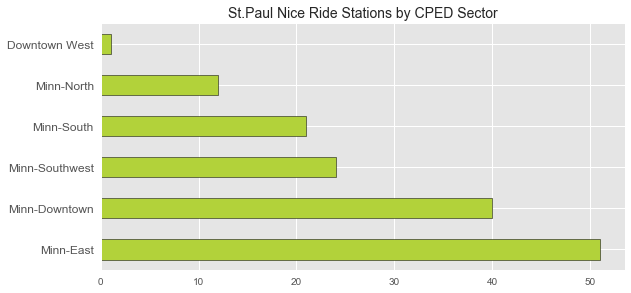

In [36]:
fig = plt.figure(figsize=(8, 4))
ax = fig.gca()
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("St.Paul Nice Ride Stations by CPED Sector", fontsize=14);
minny_stations.cped_sector.value_counts().plot(kind='barh', color="#B2D23A",
                                             edgecolor="#000000");

**Council Wards: Minneapolis is divided into thirteen wards, each containing approximately 30,000 residents. Ward boundaries are redrawn at least once every ten years following the federal census to assure the population remains evenly apportioned among all wards.** http://www.ci.minneapolis.mn.us/council/maps/index.htm<br>
http://www.minneapolismn.gov/maps/about_maps_city-wards

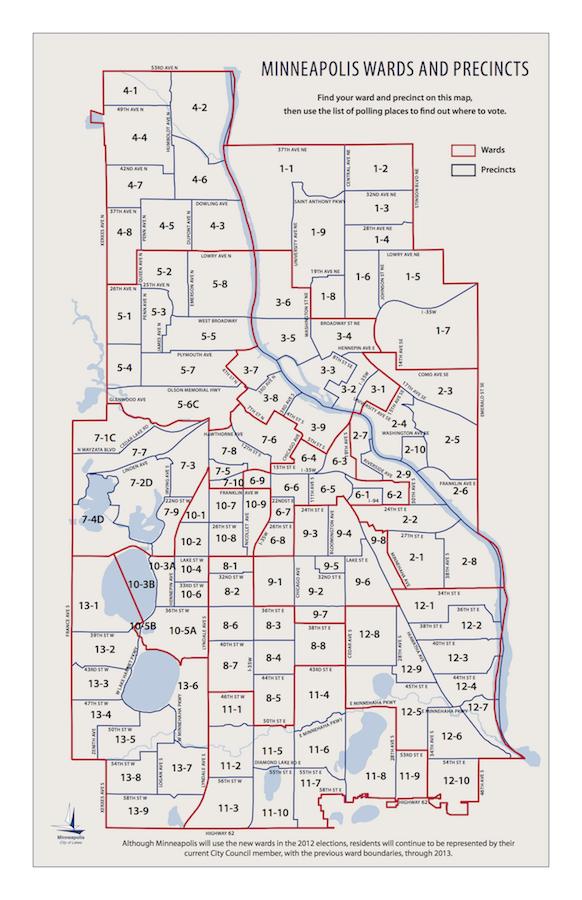

In [37]:
minny_council_wards = Image('Images/wcms1p-099973.png', width=400, height=100)
minny_council_wards

### Minneapolis station/dock information by council ward

In [38]:
m = pd.DataFrame(minny_stations['number_docks'].groupby([minny_stations['council_ward']]).sum())
m = m.rename(columns={'number_docks':'docks'})
i = pd.DataFrame(minny_stations['number_docks'].groupby(minny_stations['council_ward']).mean())
i = i.round(2); i = i.rename(columns={'number_docks':'d/p/s'})
n = pd.DataFrame(minny_stations['number_docks'].groupby([minny_stations['council_ward']]).count())
n = n.rename(columns={'number_docks':'stations'})
minny_wards = pd.concat([n, m, i], axis=1); print(minny_wards)
#print(minny_wards.sort_values('number of stations', ascending=False))

              stations  docks  d/p/s
council_ward                        
1                    3     41  13.67
2                   33    649  19.67
3                   26    450  17.31
4                    2     30  15.00
5                    6     86  14.33
6                    9    145  16.11
7                   40    749  18.73
8                    1     11  11.00
9                    6     94  15.67
10                  14    252  18.00
12                   5     95  19.00
13                   4     86  21.50


## St. Paul

In [39]:
stp_stations.number_docks.value_counts()

15    38
19    10
23     2
Name: number_docks, dtype: int64

In [40]:
dock_sort = stp_stations.sort(['number_docks'], ascending=0); dock_sort.head(2)

,terminal,number_docks,map_label,location,latitude,longitude,zip,city,neighborhood,cped_sector,council_ward,loc_just,coordinates
119,30119,23,Union Depot,229 E. 4th St,44.948399,-93.086584,55101,St. Paul,St. Paul Downtown,St. Paul Downtown,2,St. Paul,"(44.948399, -93.086584)"
100,30100,23,Lake Como Pavilion,1360 Lexington Parkway North,44.981914,-93.143383,55103,St. Paul,Como,St. Paul North,5,Attraction,"(44.981914, -93.143383)"


In [41]:
stp_stations.number_docks.sum()

806

In [42]:
stp_stations.number_docks.mean()

16.12

In [43]:
stp_stations.neighborhood.nunique()

13

### St. Paul station/dock information by zip code

In [44]:
stp_stations.zip.nunique()

10

In [45]:
b = pd.DataFrame(stp_stations['number_docks'].groupby([stp_stations['zip']]).sum())
b = b.rename(columns={'number_docks':'docks'})
d = pd.DataFrame(stp_stations['number_docks'].groupby(stp_stations['zip']).mean())
d = d.round(2); d = d.rename(columns={'number_docks':'d/p/s'})
f = pd.DataFrame(stp_stations['number_docks'].groupby([stp_stations['zip']]).count())
f = f.rename(columns={'number_docks':'stations'})
stp_zip = pd.concat([f, b, d], axis=1); print(stp_zip)
#print(stp_zip.sort_values('number of stations', ascending=False))

       stations  docks  d/p/s
zip                          
55101        12    204  17.00
55102        11    173  15.73
55103         3     53  17.67
55104        12    184  15.33
55105         4     60  15.00
55107         2     34  17.00
55108         1     15  15.00
55111         2     38  19.00
55114         2     30  15.00
55155         1     15  15.00


### St. Paul station/dock information by CPED sector

In [46]:
r = pd.DataFrame(stp_stations['number_docks'].groupby([stp_stations['cped_sector']]).sum())
r = r.rename(columns={'number_docks':'docks'})
a = pd.DataFrame(stp_stations['number_docks'].groupby(stp_stations['cped_sector']).mean())
a = a.round(2); a = a.rename(columns={'number_docks':'d/p/s'})
i = pd.DataFrame(stp_stations['number_docks'].groupby([stp_stations['cped_sector']]).count())
i = i.rename(columns={'number_docks':'stations'})
stp_cped = pd.concat([i, r, a], axis=1); #print(stp_cped)
print(stp_cped.sort_values('stations', ascending=False))

                   stations  docks  d/p/s
cped_sector                              
St. Paul Downtown        21    343  16.33
St. Paul West            16    248  15.50
St. Paul Central         10    158  15.80
St. Paul North            3     57  19.00


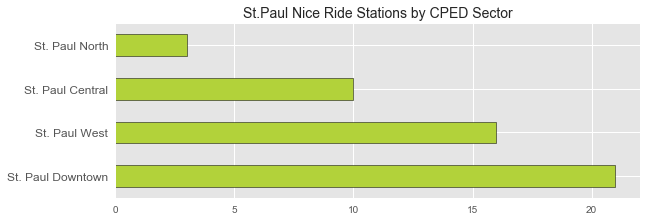

In [47]:
fig = plt.figure(figsize=(8, 3))
ax = fig.gca()
plt.xticks([0, 5, 10, 15, 20])
plt.yticks(fontsize=12)
plt.tight_layout()
plt.title("St.Paul Nice Ride Stations by CPED Sector", fontsize=14);
stp_stations.cped_sector.value_counts().plot(kind='barh', color="#B2D23A",
                                             edgecolor="#000000");

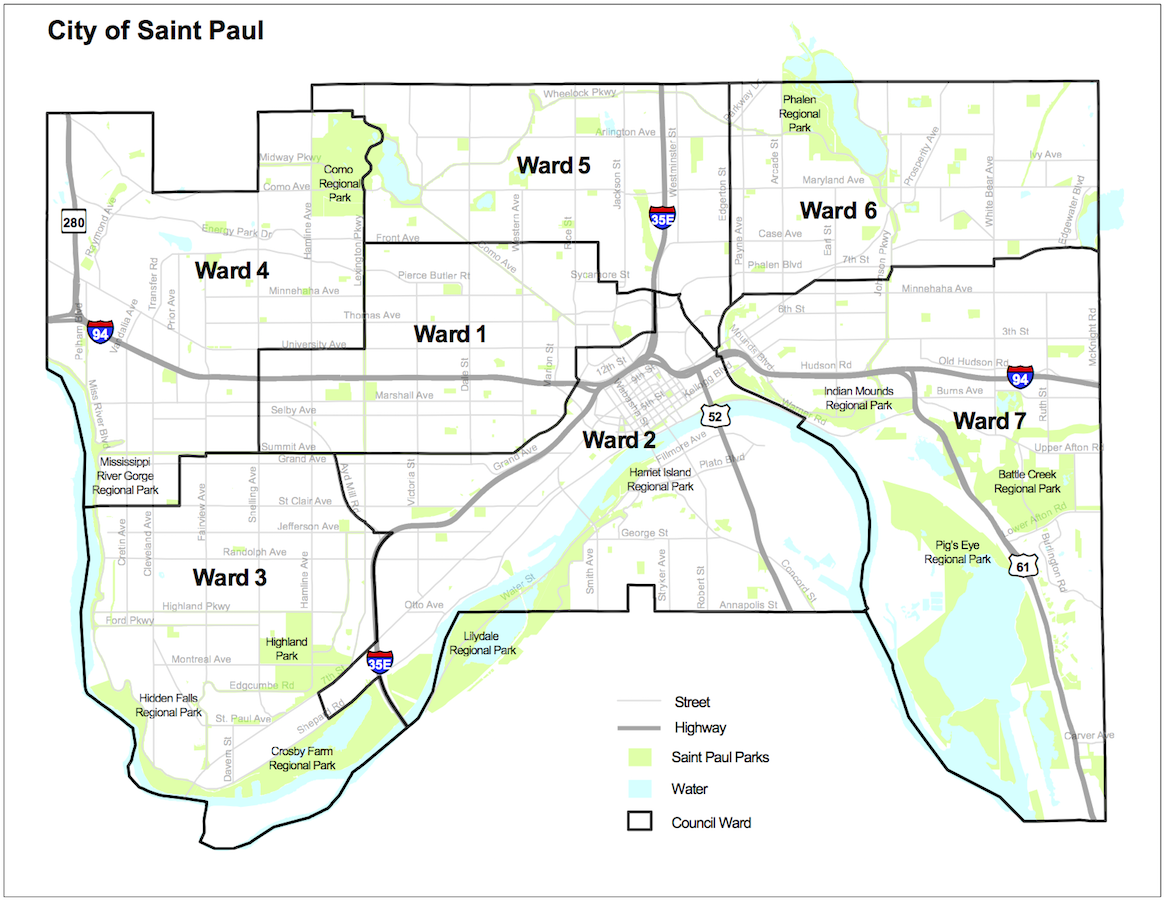

In [48]:
stp_council_wards = Image('Images/SaintPaulCouncilWard.png', width=500, height=100)
stp_council_wards

### St. Paul station/dock information by council ward

In [49]:
s = pd.DataFrame(stp_stations['number_docks'].groupby([stp_stations['council_ward']]).sum())
s = s.rename(columns={'number_docks':'docks'})
t = pd.DataFrame(stp_stations['number_docks'].groupby(stp_stations['council_ward']).mean())
t = t.round(2); t = t.rename(columns={'number_docks':'d/p/s'})
p = pd.DataFrame(stp_stations['number_docks'].groupby([stp_stations['council_ward']]).count())
p = p.rename(columns={'number_docks':'stations'})
stp_wards = pd.concat([p, s, t], axis=1); print(stp_wards)
#print(stp_wards.sort_values('number of stations', ascending=False))

              stations  docks  d/p/s
council_ward                        
1                   10    154  15.40
2                   23    377  16.39
3                    7    117  16.71
4                    9    135  15.00
5                    1     23  23.00


**Appears St.Paul CPED Sectors and Council Wards with few stations tended to have a larger dock count. Is that as effective as more stations with fewer docks in encouraging ridership in as yet under-served areas of the cities? Does the upfront cost per station change significantly when dock count is higher/lower? **

### Save complete station data set

In [50]:
station_data.to_csv('Data/station_data.csv', index=False)